In [72]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score

In [73]:
def load_dataset(load_fn, sample_output=False):
    data = load_fn();
    df = pd.DataFrame(data= np.c_[data['data'], data['target']],
                     columns= data['feature_names'] + ['target']);
    
    if sample_output:
        print(df.head(5));

    return df;

data = load_dataset(load_iris, True);

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  


In [74]:
def input_layer(data, target='target'):
    # Input "Layer"
    X = data.drop(columns=target,axis=1);
    Y = data[['target']]

    x_train,x_test,y_train,y_test = train_test_split(X,Y,train_size=0.5,random_state=12);
    x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,train_size=0.5,random_state=12);

    return x_train,x_test,x_val,y_train,y_test,y_val;


In [75]:
# Kernel Functions 
def uniform(x, y):
    return (np.abs(x/y) <= 1) and 1/2 or 0

def triangle(x, y):
    return (np.abs(x/y) <= 1) and  (1 - np.abs(x/y)) or 0

def gaussian(x, y):
    return (1.0/np.sqrt(2*np.pi))* np.exp(-.5*(x/y)**2)

def laplacian(x, y):
    return (1.0/(2*y))* np.exp(-np.abs(x/y))

def epanechnikov(x, y):
    return (np.abs(x/y)<=1) and ((3/4)*(1-(x/y)**2)) or 0

In [76]:
def pattern_layer(test_input, x_train, kernel=uniform, sigma=0):
  """
  Pattern Layer: 
    This Layer contains one Neuron per Observation in Training Set. 
    First the Euclidean Distance between the Pattern and the Test Input is calculated. 
    Then the Kernel Function is applied to the Euclidean Distance and the Smoothing Parameter. 
    `test_input`: A Pandas Series containing the Test Input.
    `kernel`: Kernel Function, defaults to `uniform`.
    `sigma`: Smoothing Parameter, defaults to 0.


    Returns a list of Kernel Values, one for each Observation in the Training Set.

  """
  k_values=[];
  for i,p in enumerate(x_train.values):
    edis = np.linalg.norm(p-test_input); #find eucliden distance
    k = kernel(edis,sigma); #pass values of euclidean dist and 
    #smoothing parameter to kernel function
    k_values.append(k);
  return k_values;

In [77]:
def summation_layer(k_values, y_train, class_counts):
  """
  Summation Layer:
    This Layer contains one Neuron per Class in the Training Set. 
    First the Kernel Values are summed up for each Class. 
    Then the Sum of Kernel Values for each Class is divided by the Number of Observations in that Class. 
    `k_values`: A list of Kernel Values, one for each Observation in the Training Set.
    `Y_train`: A Pandas Series containing the Target Variable for the Training Set.
    `class_counts`: A list of the Number of Observations in each Class in the Training Set.

    Returns a list of Average Kernel Values, one for each Class in the Training Set.
  """
  # ToDo: Generalize for more than 3 classes
  summed =[0,0,0];
  for i,c in enumerate(class_counts):
    # find all the kernel values for the class i
    val = (y_train['target']==class_counts.index[i]).values;
    # convert the list of kernel values to a numpy array
    k_values = np.array(k_values);
    # sum the kernel values for class i
    summed[i] = np.sum(k_values[val]);
  
  avg_sum = list(summed/y_train.value_counts());
  return avg_sum

In [78]:
def output_layer(avg_sum,class_counts):
  """
  Output Layer:
    This Layer contains one Neuron per Class in the Training Set. 
    The Neuron with the highest Average Kernel Value is the Predicted Class.
    `avg_sum`: A list of Average Kernel Values, one for each Class in the Training Set.
    `class_counts`: A list of the Number of Observations in each Class in the Training Set.

    Returns the Predicted Class, determined by the Neuron with the highest Average Kernel Value.
  """
  maxv = max(avg_sum);
  label = class_counts.index[avg_sum.index(maxv)][0];

  return label

In [79]:
def pnn(x_train,y_train,x_test,kernel=uniform,sigma=0):
  """
  PNN:
    This function brings all the layers together to create a Probabilistic Neural Network.
    `X_train`: A Pandas DataFrame containing the Training Set.
    `Y_train`: A Pandas Series containing the Target Variable for the Training Set.
    `X_test`: A Pandas DataFrame containing the Test Set.
    `kernel`: Kernel Function, defaults to `uniform`.
    `sigma`: Smoothing Parameter, defaults to 0.

    Returns a list of Predicted Classes, one for each Observation in the Test Set.
  """
  class_counts = y_train.value_counts()
  labels=[];
  #Passing each sample observation
  for s in x_test.values:
    k_values = pattern_layer(s, x_train, kernel, sigma);
    avg_sum = summation_layer(k_values, y_train, class_counts);
    label = output_layer(avg_sum, class_counts);
    labels.append(label);
  print('Labels Generated for bandwidth:',sigma);
  return labels;

In [80]:
# Split data
x_train,x_test,x_val,y_train,y_test,y_val = input_layer(data);

# Candidate Kernels 
kernels = ['Gaussian', 'Uniform', 'Laplacian', 'Triangular','Epanechnikov'];
sigmas = [0.05,0.5,0.8,1,1.2]

results = pd.DataFrame(columns=['Kernel','Smoothing Param','Accuracy','F1-Score']);
for k in kernels:
  if k == 'Gaussian':
    k_func = gaussian
  elif k == 'Uniform':
    k_func = uniform
  elif k == 'Laplacian':
    k_func = laplacian
  elif k == 'Triangular':
    k_func = triangle
  elif k == 'Epanechnikov':
    k_func = epanechnikov

  for b in sigmas:
    pred = pnn(x_train, y_train, x_val, k_func, b)
    accuracy = accuracy_score(y_val.values, pred)
    f1 = f1_score(y_val.values, pred, average='weighted')
    results.loc[len(results.index)] = [k, b, accuracy, f1]


Labels Generated for bandwidth: 0.05
Labels Generated for bandwidth: 0.5
Labels Generated for bandwidth: 0.8
Labels Generated for bandwidth: 1
Labels Generated for bandwidth: 1.2
Labels Generated for bandwidth: 0.05
Labels Generated for bandwidth: 0.5
Labels Generated for bandwidth: 0.8
Labels Generated for bandwidth: 1
Labels Generated for bandwidth: 1.2
Labels Generated for bandwidth: 0.05
Labels Generated for bandwidth: 0.5
Labels Generated for bandwidth: 0.8
Labels Generated for bandwidth: 1
Labels Generated for bandwidth: 1.2
Labels Generated for bandwidth: 0.05
Labels Generated for bandwidth: 0.5
Labels Generated for bandwidth: 0.8
Labels Generated for bandwidth: 1
Labels Generated for bandwidth: 1.2
Labels Generated for bandwidth: 0.05
Labels Generated for bandwidth: 0.5
Labels Generated for bandwidth: 0.8
Labels Generated for bandwidth: 1
Labels Generated for bandwidth: 1.2


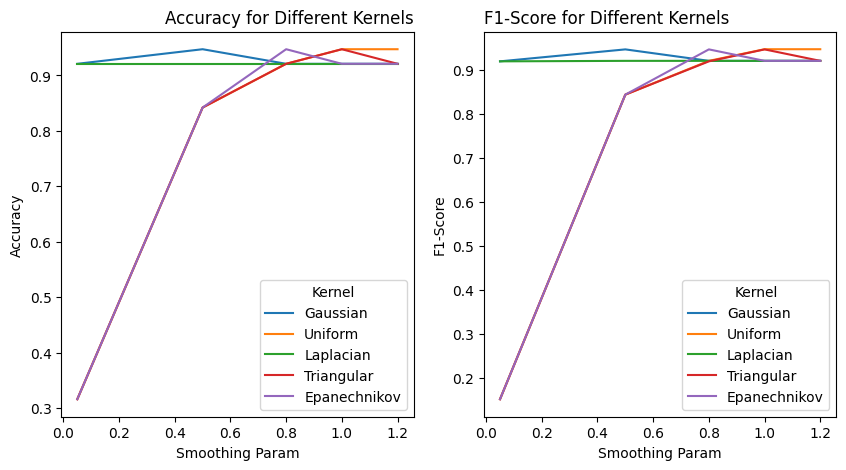

In [81]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(121)
sns.lineplot(y=results['Accuracy'],x=results['Smoothing Param'],hue=results['Kernel']);
plt.title('Accuracy for Different Kernels',loc='right');

plt.subplot(122)
sns.lineplot(y=results['F1-Score'],x=results['Smoothing Param'],hue=results['Kernel']);
plt.title('F1-Score for Different Kernels',loc='left');

plt.show()